In [11]:
from TrajGen import (
    TrajectoryGenerator,
    DataPoint,
    TrajectoryGeneratorCollection,
    WayPoint,
    color_hex,
    rand_24_bit,
    plot_trajectory,
    plot_datapoint,
    setup_map,
)
import os
import gpxpy
import folium
import random
from typing import Tuple, List
from folium import plugins
import matplotlib.pyplot as plt
import time
import pandas as pd
from datetime import datetime
from datetime import timedelta
import numpy as np
import uuid
import utm 
import gpxpy
import json
from shapely.geometry import Point, Polygon, LineString
from shapely import ops

import multiprocessing
import uuid
import pickle

# import backend.DisorientationDetectors as dds
# import backend.utils as utils

import folium
# import backend.settings as settings
import matplotlib.pyplot as plt
from adtk.visualization import plot
import numpy as np
import geohash_hilbert as ghh
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.dates import DateFormatter


# Settings
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

bits_per_char = 2
center = [55.3923666589426, 10.386784608945067]
user = "d1b0c137-1cd0-4430-ad88-4dc24c88f3ad"



center = [55.39594, 10.38831]

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

In [12]:
kmh_to_ms = (1000 / (60 * 60))
# Set trajectory charateristics
mean_speed = 4.0 * kmh_to_ms  # Average human walking speed in m/s
std_speed = 0.5 * kmh_to_ms   # Deviation in walking speed in m/s
mean_time_delta = 5.
std_time_delta = 20.

def ncrands(n: int, min_: int, max_: int):
    rs = []; r0 = np.random.randint(min_, max_)
    for _ in range(n):
        r1 = np.random.randint(min_, max_ - 1) 
        r2 = (r0 + r1 + 1) % max_
        r0 = r2
        rs.append(r2)
    return rs

def generate_pattern(profile):
    is_anom = profile[0]
    n_patterns = profile[1]
    pattern = profile[2]
    start_pair = WayPoint(
        latitude = pattern[0][0],
        longitude = pattern[0][1],
        duration = 60, # In seconds
        std = 0, # In meters
    )
    end_pair = WayPoint(
        latitude = pattern[-1][0],
        longitude = pattern[-1][1],
        duration = 60, # In seconds
        std = 0, # In meters
    )
    middle_pairs = []
    for i in range(1, len(pattern) - 1):
        middle_pairs.append(
            WayPoint(
                latitude = pattern[i][0],
                longitude = pattern[i][1],
                duration = 0, # Seconds
                std = 0, # In meters
            )
        )
    list_waypoints = [(is_anom, n_patterns, 
            [start_pair] + middle_pairs + [end_pair]
        )
    ]
    return list_waypoints

In [26]:
locations = {    
#     "home": [55.368179431550395, 10.405867365319056],
#     "fakta1": [55.364289704748835, 10.392898632602034],
    "o": [55.3788469871221, 10.39611857882814],
    "d": [55.393056110962824, 10.39613230095957],
#     "fakta": [55.364467731441266, 10.392707986720698],
#     "lidl": [55.37274058513472, 10.40862169924273],
#     "land": [55.36595581773891, 10.395365460132705],
#     "hcl": [55.37298467679492, 10.39972562981267],
#     "forsker": [55.36930434657332, 10.413675245950772],
}

profiles = {
    #### home --> fakta (5 + 2). fakta --> home (3 + ?)
    "home-fakta-norm": [False, 8, [locations["o"], locations["d"]]],
    "way1": [True, 1,
        [
            locations["o"],
#             [55.384855213063425, 10.392786076138346],
#             [55.385884385147996, 10.389239127302238],
            [55.38782669329171, 10.393347463723916],
            [55.38927611482045, 10.39339849895897],
#             locations["d"],
        ]
    ],
    "way1-": [None, 1,
        [
#             locations["o"],
#             [55.384855213063425, 10.392786076138346],
#             [55.385884385147996, 10.389239127302238],
#             [55.38782669329171, 10.393347463723916],
            [55.38927611482045, 10.39339849895897],
            locations["d"],
        ]
    ],
#     "way2": [True, 1,
#         [
#             locations["o"],
# #             [55.384086940386624, 10.397251659205388],
# #             [55.38556548961933, 10.397328212057968],
#             [55.383782526329796, 10.398604092934264],
#             [55.38556548961933, 10.397404764910544],
# #             locations["d"],
#         ]
#     ],
#     "way3": [True, 1,
#              [
#                 locations["o"],
#                 [55.38817318944134, 10.399244189257079],
#                 [55.389655525494476, 10.398728311807643],
# #                 locations["d"],
#              ]
#     ],
    "way4": [True, 1, 
             [
                 locations["o"],
                 [55.38662363307439, 10.39258193519814],
#                  locations["d"],
             ]
    ],
    "way4-": [None, 1, 
             [
                 #locations["o"],
                 [55.38662363307439, 10.39258193519814],
                 locations["d"],
             ]
    ],
    "way5": [True, 1,
             [
                locations["o"],
                [55.39103439286466, 10.39490474953535],
                [55.39191339571527, 10.39472267514143],
#                 locations["d"],
             ]
    ],
    "way5-": [None, 1,
             [
                #locations["o"],
                #[55.39103439286466, 10.39490474953535],
                [55.39191339571527, 10.39472267514143],
                locations["d"],
             ]
    ]
#     "home-fakta-devi1": [True, 1,
#         [
#             locations["home"],
#             [55.3688962638592, 10.3985793181517],
#             [55.3653719858155, 10.398257453074862],
#             locations["fakta"],
#         ]
#     ],
#     "home-fakta-devi2": [True, 1,
#         [
#             locations["home"],
#             [55.3687011563267, 10.401390273156068],
#             [55.36571345209057, 10.401175696438177],
#             locations["fakta"],
#         ]
#     ],
#     ##
#     "fakta-home-devi1": [True, 1,
#         [
#             locations["fakta"],
#             [55.36243178318969, 10.40737547068215],
#             locations["home"],
#         ]
#     ],
#     "fakta-home-devi2": [True, 1,
#         [
#             locations["fakta"],
#             [55.36278400458655, 10.404573436222652],
#             [55.36478675391273, 10.406346657883642],
#             [55.36535525783513, 10.407642473712826],
#             locations["home"],
#         ]
#     ],
#     "fakta-home-devi3": [True, 1,
#         [
#             locations["fakta"],
#             [55.3629572473624, 10.403128344570984],
#             [55.36487197631148, 10.403793532396445],
#             [55.36544515740819, 10.405531603811362],
#             locations["home"],
#         ]
#     ],

#     ####  home --> lidl (5 + 1) -->
#     "home-lidl-norm":  [False, 6, [locations["home"], locations["lidl"]]],
#     "home-lidl-devi1": [True, 1,
#         [
#             locations["home"],
#             [55.368654525477595, 10.40214269932413],
#             [55.3708337247534, 10.402759934790717],
#             locations["lidl"],
#         ]
#     ],
#     "home-lidl-devi2": [True, 1,
#         [
#             locations["home"],
#             [55.370331240589394, 10.406725459642242],
#             [55.37128103764875, 10.406597871562429],
#             locations["lidl"],
#         ]
#     ],
#     "home-lidl-devi3": [True, 1,
#         [
#             locations["home"],
#             [55.3689231075168, 10.398002999198704],
#             [55.37116098319547, 10.40152045581184],
#             locations["lidl"],
#         ]
#     ],
#     "home-lidl-devi4": [True, 1,
#         [
#             locations["home"],
#             [55.369053472678395, 10.393548828596202],
#             [55.37191053461741, 10.395020807722354],
#             [55.37123702529128, 10.401443989363726],
#             locations["lidl"],
#         ]
#     ],
#     "lidl-home-norm":  [False, 11 + 5, [locations["lidl"], locations["home"]]],
#     #### home --> land (5 + 1) --> fakta (6)
#     "home-land-norm":  [False, 6, [locations["home"], locations["land"]]],
#     "home-land-devi1": [True, 1,
#         [
#             locations["home"],
#             [55.367116410064604, 10.394117856530032],
#             locations["land"],
#         ]
#     ],
#     "land-fakta-norm":  [False, 7, [locations["land"], locations["fakta"]]],
#     ##### home --> hcl (5) --> lidl (5)
#     ##### hcl --> home (1)
#     "home-hcl-norm": [False, 6,
#         [
#             locations["home"],
#             [55.36922148996438, 10.393627298339139],
#             locations["hcl"],
#         ]
#     ],
#     "hcl-lidl-norm": [False, 5,
#         [
#             locations["hcl"],
#             [55.37408034921968, 10.403112588773388],
#             locations["lidl"],
#         ]
#     ],
#     "hcl-home-devi1": [False, 1,
#         [
#             locations["hcl"],
#             [55.37124927486343, 10.401271583186231],
#             [55.37015850074101, 10.406448780293063],
#             locations["home"],
#         ]
#     ],
#     ####
}

In [5]:
path_counter_anom = 0
path_counter_norm = 0
for profile in profiles:
    if profiles[profile][0] == True:
        path_counter_anom += profiles[profile][1]
    else:
        path_counter_norm += profiles[profile][1]
print("N paths: ", path_counter_anom + path_counter_norm)
print("Norm   : ", path_counter_norm)
print("Anom   : ", path_counter_anom)
print("Ratio  : ", path_counter_anom / (path_counter_anom + path_counter_norm))



N paths:  11
Norm   :  8
Anom   :  3
Ratio  :  0.2727272727272727


In [27]:
patterns_waypoint_list = []

for profile in profiles:
    patterns_waypoint_list.extend(
        generate_pattern(
            profile = profiles[profile],
        )
    )
patterns_waypoint_list

map_ = setup_map(center)

# map_ = plot_datapoint([start_latitude, start_longitude], color = "red", map_ = map_)
# map_ = plot_datapoint([middle_latitude, middle_longitude], color = "green", map_ = map_)
# map_ = plot_datapoint([end_latitude, end_longitude], color = "green", map_ = map_)

trajectories1 = []
for anomaly, n, waypoints in patterns_waypoint_list:
    for _ in range(n):
        random.seed(time.time())
        color = "#" + str(color_hex(num = rand_24_bit()))
        print(waypoints)
        trajectory_generator = TrajectoryGenerator(
            waypoints = waypoints,
            mean_time_delta = mean_time_delta,
            std_time_delta = std_time_delta,
            mean_speed = mean_speed,
            std_speed = std_speed,
            # https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0219890
            # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6638960/
            # np.mean(np.abs(np.random.normal(0, 9, size=1000))) approx 7
            std_datapoint = 8.75,
        )
        map_ = plot_trajectory(
            trajectory_generator.to_latlon(),
            color = color,
            map_ = map_,
        )
        trajectories1.append((anomaly, trajectory_generator))
map_

[<TrajGen.WayPoint object at 0x7f097918d5e0>, <TrajGen.WayPoint object at 0x7f097918d310>]
[<TrajGen.WayPoint object at 0x7f097918d5e0>, <TrajGen.WayPoint object at 0x7f097918d310>]
[<TrajGen.WayPoint object at 0x7f097918d5e0>, <TrajGen.WayPoint object at 0x7f097918d310>]
[<TrajGen.WayPoint object at 0x7f097918d5e0>, <TrajGen.WayPoint object at 0x7f097918d310>]
[<TrajGen.WayPoint object at 0x7f097918d5e0>, <TrajGen.WayPoint object at 0x7f097918d310>]
[<TrajGen.WayPoint object at 0x7f097918d5e0>, <TrajGen.WayPoint object at 0x7f097918d310>]
[<TrajGen.WayPoint object at 0x7f097918d5e0>, <TrajGen.WayPoint object at 0x7f097918d310>]
[<TrajGen.WayPoint object at 0x7f097918d5e0>, <TrajGen.WayPoint object at 0x7f097918d310>]
[<TrajGen.WayPoint object at 0x7f09791b19a0>, <TrajGen.WayPoint object at 0x7f0978d73400>, <TrajGen.WayPoint object at 0x7f09791b1c70>]
[<TrajGen.WayPoint object at 0x7f0978d73520>, <TrajGen.WayPoint object at 0x7f0978d732e0>]
[<TrajGen.WayPoint object at 0x7f0978d73610>,

In [16]:
cp = sns.color_palette("tab10")
cp_list = list(cp.as_hex())
cp

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

55.37874378769377 55.39305611576334 10.392535019349033 10.397235244339623


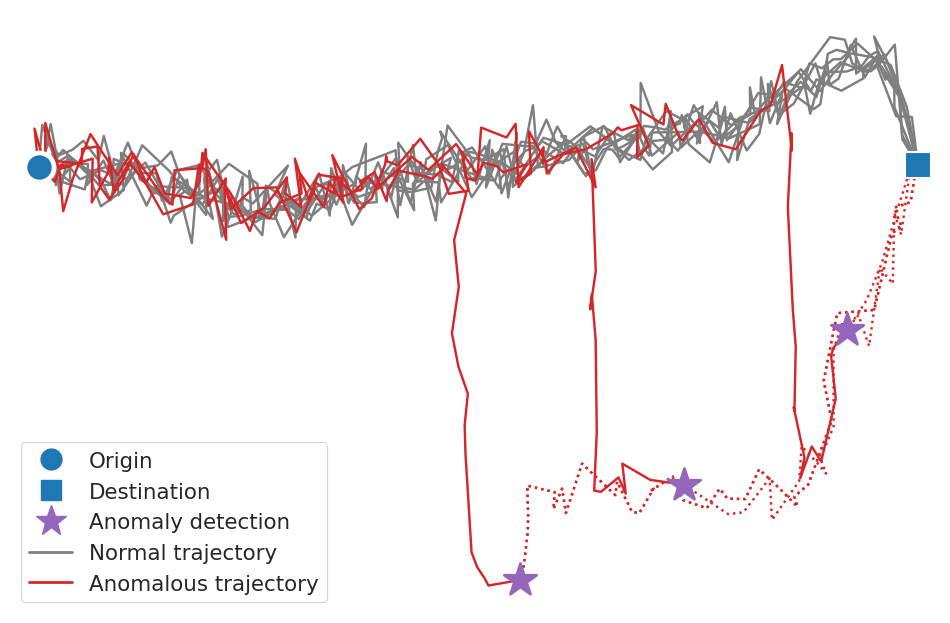

In [52]:
# Plots
sns.set_theme(style = "whitegrid")
sns.set_context("paper", font_scale = 1.75,  rc = {"lines.linewidth": 1.75})

fig, axs = plt.subplots(1, sharex = True, sharey = True)
xss = []
yss = []

for traj_gen in trajectories1:
    xs = [i for i, j in list(traj_gen[1].to_latlon())]
    ys = [j for i, j in list(traj_gen[1].to_latlon())]
    xss.extend(xs)
    yss.extend(ys)

x_max = np.max(xss)
x_min = np.min(xss)
x_margin = (x_max - x_min) * 0.025

y_max = np.max(yss)
y_min = np.min(yss)
y_margin = (y_max - y_min) * 0.05

# uid = "2a2202df-45fc-4697-953c-f80d6d06f610"
is_set = False

for traj_gen in trajectories1:
    xs = [i for i, j in list(traj_gen[1].to_latlon())]
    ys = [j for i, j in list(traj_gen[1].to_latlon())]
    if traj_gen[0] == False:
        sns.lineplot(
            x = xs, y = ys, sort = False, ax = axs,
            **{"color": cp_list[7]}, # Gray
        )
    elif traj_gen[0] == True:
        sns.lineplot(
            x = xs, y = ys, sort = False, ax = axs,
            **{"color": cp_list[3], "linestyle": "-"}, # Red
        )
    elif traj_gen[0] == None:
#         if is_set == False:
        sns.lineplot(
            x = xs, y = ys, sort = False, ax = axs,
            **{"color": cp_list[3], "linestyle": ":"}, # Red
        )
#             is_set = True
        
traj_gen = trajectories1[-3]
xs = [i for i, j in list(traj_gen[1].to_latlon())]
ys = [j for i, j in list(traj_gen[1].to_latlon())]
sns.lineplot(
    x = xs, y = ys, sort = False, ax = axs,
    **{"color": cp_list[3], "linestyle": ":"}, # Red
)

    
# for i in range(dfs.shape[0]): 
#     xs = dfs.iloc[i]["longitude"].values
#     ys = dfs.iloc[i]["latitude"].values
#     temp_df = dfs.iloc[i]
#     if temp_df[temp_df["anom_start"] == True].shape[0] == 0:
        
#         sns.lineplot(
#             x = xs, y = ys, sort = False, ax = axs,
#             **{"color": cp_list[7]}, # Gray
#         )
#     else:
#         print(temp_df["uid"].values[0])
#         if uid == temp_df["uid"].values[0]:
#             sns.lineplot(
#                 x = xs, y = ys, sort = False, ax = axs,
#                 **{"color": cp_list[3], "linestyle": "--"}, # Red
#             )
#         else:

#             sns.lineplot(
#                 x = xs, y = ys, sort = False, ax = axs,
#                 **{"color": cp_list[3]}, # Red
#             )

xs = [i for i, j in list(trajectories1[0][1].to_latlon())]
ys = [j for i, j in list(trajectories1[0][1].to_latlon())]
start_x = xs[0]; start_y = ys[0]
end_x = xs[-1]; end_y = ys[-1]

sns.scatterplot(
    x = [start_x], y = [start_y], ax = axs,
    **{"zorder":len(trajectories1) + 1, "s": 1750, "marker": ".", "color": cp_list[0], "edgecolor": "white"}
)
sns.scatterplot(
    x = [end_x], y = [end_y], ax = axs,
    **{"zorder":len(trajectories1) + 2, "s": 350, "marker": "s", "color": cp_list[0], "edgecolor": "white"},
)
# axs.set_title('All trajectories in 1st dataset')
axs.set_xlim([x_min - x_margin, x_max + x_margin])
axs.set_ylim([y_min - y_margin, y_max + y_margin])

print(x_min, x_max, y_min, y_max)

for traj_gen in trajectories1:
    xs = [i for i, j in list(traj_gen[1].to_latlon())]
    ys = [j for i, j in list(traj_gen[1].to_latlon())]
    if traj_gen[0] == True:
        # Anom start
        sns.scatterplot(
            x = [xs[-1]], y = [ys[-1]], ax = axs,
            **{"zorder":len(trajectories1) + 3, "s": 600, "marker": "*", "color": cp_list[4], "edgecolor": None},
        )


custom = [
    Line2D([], [], marker=".", markersize=10, color=cp_list[0], linestyle="None"), # Color: Blue
    Line2D([], [], marker="s", markersize=5, color=cp_list[0], linestyle="None"), # Color: Blue
    Line2D([], [], marker="*", markersize=7.5, color=cp_list[4], linestyle="None"),
    Line2D([0], [0], lw = 2, color=cp_list[7], linestyle="-"), # Color: Gray
    Line2D([0], [0], lw = 2, color=cp_list[3], linestyle="-"), # Color: Red     
#     Line2D([0], [0], lw = 2, color=cp_list[3], linestyle="-"), # Color: Red     
]

plt.legend(
    custom, [
        "Origin", "Destination",
        "Anomaly detection",
        "Normal trajectory",
        "Anomalous trajectory",
#         "Trajectory of interest",
    ], loc  = "lower left", markerscale = 3)

axs.axis("off")
# fig.patch.set_visible(False)
sns.despine(fig, left = True, bottom  = True, right = True, top = True)

In [191]:
def generate_trajectories(
    waypoints: List,
    start_datetime: datetime,
    gap: timedelta = timedelta(days = 1.),
    *args, **kwargs,
    ) -> TrajectoryGeneratorCollection: 
    trajectories = []
    for anomaly, n, waypoints in waypoints:
        for _ in range(n):
            random.seed(time.time())
            color = "#" + str(color_hex(num = rand_24_bit()))
            trajectory_generator = TrajectoryGenerator(waypoints = waypoints, *args, **kwargs)
            trajectories.append((anomaly, trajectory_generator))
    return TrajectoryGeneratorCollection(
        trajectory_generators = trajectories,
        start_datetime = start_datetime,
        gap = gap,
    ) 

In [ ]:
def generate_batches_deviating(n_batches, seeds):
    batches = []
    for seed in seeds:
        waypoints = generate_deviating_patterns(
            seed = seed,
            n_normal = 10,
            n_deviating = 5, 
        ) 
        kwargs = {
            "mean_time_delta": mean_time_delta,
            "std_time_delta": std_time_delta,
            "mean_speed": mean_speed,
            "std_speed": std_speed,
            "std_datapoint": 9, # 9
        }
        tgc = generate_trajectories(
            waypoints = waypoints, 
            start_datetime = datetime.now(),
            **kwargs,
        )
        main_df = tgc.to_dataframe(anom_start = True)
        batches.append(main_df.to_json(orient = "split"))
    return batches


# def read_batches(data_in):
# #     data_in = None; #df = 
# #     with open(json_file, "r") as f:
# #         data_in = json.loads(f.read())
#     batches = {}; 
#     for i, batch in enumerate(data_in): # Get each batch of trajectories
#         df_batch = pd.read_json(batch, orient = "split")
#         _data = []
#         for _, row in df_batch.iterrows():
#             df_traj = pd.read_json(row["df"], orient = "split")
#             _data.append(df_traj)
#         df_batch["df"] = _data
#         batches[i] = df_batch 
#     return batches

    
# def generate_batches_looping(n_batches):
#     batches = []
#     seeds = [i for i in range(12, 12 + n_batches + 1)]
#     for seed in seeds:
#         waypoints = generate_looping_patterns(
#             seed = seed,
#             n_normal = 10,
#             n_looping = 5, 
#         ) 
#         kwargs = {
#             "mean_time_delta": mean_time_delta,
#             "std_time_delta": std_time_delta,
#             "mean_speed": mean_speed,
#             "std_speed": std_speed,
#             "std_datapoint": 14,
#         }
#         tgc = generate_trajectories(
#             waypoints = waypoints, 
#             start_datetime = datetime.now(),
#             **kwargs,
#         )
#         main_df = tgc.to_dataframe()
#         batches.append(main_df.to_json(orient = "split"))
#     return batches

# batches0 = generate_batches_deviating(n_batches = 1)

In [ ]:
start_seed = 13
seeds = [2, 3, 5, 6, 8] # [i for i in range(start_seed, start_seed + n_batches + 1)]
n_batches = len(seeds)
batches0 = generate_batches_deviating(n_batches = n_batches, seeds = seeds)
with open("main_data_deviating_large.json", "w") as f:
    f.write(json.dumps(batches0))